# Statistics for ~short Generated Data

**Goal**: Basic stats on training and inference data for inclusion in final report

**Authors**: Owen Terry, Varun Ramamurthi, Sungjoon Park  
**Concept**: ~short (Responses less than 50 words)  
**Last edited**: 12.7.2025

## Configuration

In [2]:
# =============================================================================
# TOGGLE WHICH DATA TO ANALYZE
# =============================================================================

ANALYZE_TRAINING_CHOSEN = True      # Training data: chosen (short) responses
ANALYZE_TRAINING_REJECTED = True    # Training data: rejected (long) responses
ANALYZE_NEO_INFERENCE = True        # Neologism inference results
ANALYZE_FT_INFERENCE = False        # Fine-tuning inference results (set True when available)

# =============================================================================
# FILE PATHS
# =============================================================================

TRAINING_DATA_PATH = '../data-prep/short/short_neologism.jsonl'
NEO_INFERENCE_PATH = '../inference/mistral_with_short_inference_results.jsonl'
FT_INFERENCE_PATH = '../inference/short_ft_inference_results.jsonl'  # Update when available

# =============================================================================
# ANALYSIS PARAMETERS
# =============================================================================

SHORT_THRESHOLD = 50  # Word count threshold for "short" responses
CONFIDENCE_LEVEL = 0.95

In [6]:
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pathlib import Path

## Utility Functions

In [7]:
def load_jsonl(filepath):
    """Load JSONL file into list of dictionaries."""
    with open(filepath, 'r', encoding='utf-8') as f:
        return [json.loads(line.strip()) for line in f]


def extract_word_counts(data, field):
    """Extract word counts from a specific field in the data."""
    return np.array([len(item[field].split()) for item in data])


def compute_stats(counts, confidence=0.95):
    """Compute descriptive statistics and confidence interval."""
    n = len(counts)
    ci = stats.t.interval(confidence, n - 1, np.mean(counts), stats.sem(counts))
    return {
        'n': n,
        'mean': np.mean(counts),
        'median': np.median(counts),
        'std': np.std(counts, ddof=1),
        'min': np.min(counts),
        'max': np.max(counts),
        'q25': np.percentile(counts, 25),
        'q75': np.percentile(counts, 75),
        'ci_lower': ci[0],
        'ci_upper': ci[1]
    }


def print_stats(name, s):
    """Print formatted statistics."""
    print(f"\n{name}")
    print("-" * 45)
    print(f"  Sample Size:      {s['n']}")
    print(f"  Mean:             {s['mean']:.2f} words")
    print(f"  Median:           {s['median']:.2f} words")
    print(f"  Std Dev:          {s['std']:.2f} words")
    print(f"  Range:            [{s['min']:.0f}, {s['max']:.0f}]")
    print(f"  IQR:              [{s['q25']:.2f}, {s['q75']:.2f}]")
    print(f"  95% CI:           [{s['ci_lower']:.2f}, {s['ci_upper']:.2f}]")


def print_threshold_distribution(counts, thresholds=[25, 50, 75, 100, 150]):
    """Print cumulative distribution at various thresholds."""
    total = len(counts)
    print("\n  Distribution by threshold:")
    for t in thresholds:
        under = np.sum(counts < t)
        print(f"    < {t:3d} words: {under:4d} ({under/total*100:5.2f}%)")

## Load Data

In [8]:
datasets = {}  # Store all loaded datasets and their word counts

# Training data
if ANALYZE_TRAINING_CHOSEN or ANALYZE_TRAINING_REJECTED:
    training_data = load_jsonl(TRAINING_DATA_PATH)
    print(f"Loaded {len(training_data)} training examples from {TRAINING_DATA_PATH}")
    
    if ANALYZE_TRAINING_CHOSEN:
        datasets['Training: Chosen (short)'] = extract_word_counts(training_data, 'chosen')
    if ANALYZE_TRAINING_REJECTED:
        datasets['Training: Rejected (long)'] = extract_word_counts(training_data, 'rejected')

# Neologism inference
if ANALYZE_NEO_INFERENCE:
    if Path(NEO_INFERENCE_PATH).exists():
        neo_data = load_jsonl(NEO_INFERENCE_PATH)
        datasets['Neologism Inference'] = extract_word_counts(neo_data, 'response')
        print(f"Loaded {len(neo_data)} neologism inference results from {NEO_INFERENCE_PATH}")
    else:
        print(f"Neologism inference file not found: {NEO_INFERENCE_PATH}")

# Fine-tuning inference
if ANALYZE_FT_INFERENCE:
    if Path(FT_INFERENCE_PATH).exists():
        ft_data = load_jsonl(FT_INFERENCE_PATH)
        datasets['Fine-tuning Inference'] = extract_word_counts(ft_data, 'response')
        print(f"Loaded {len(ft_data)} fine-tuning inference results from {FT_INFERENCE_PATH}")
    else:
        print(f"Fine-tuning inference file not found: {FT_INFERENCE_PATH}")

print(f"\nDatasets to analyze: {list(datasets.keys())}")

Loaded 1030 training examples from ../data-prep/short/short_neologism.jsonl
Loaded 300 neologism inference results from ../inference/mistral_with_short_inference_results.jsonl

Datasets to analyze: ['Training: Chosen (short)', 'Training: Rejected (long)', 'Neologism Inference']


## Descriptive Statistics

In [9]:
all_stats = {}

print("=" * 60)
print("WORD COUNT STATISTICS")
print("=" * 60)

for name, counts in datasets.items():
    s = compute_stats(counts, CONFIDENCE_LEVEL)
    all_stats[name] = s
    print_stats(name, s)
    print_threshold_distribution(counts)

WORD COUNT STATISTICS

Training: Chosen (short)
---------------------------------------------
  Sample Size:      1030
  Mean:             40.94 words
  Median:           42.00 words
  Std Dev:          10.08 words
  Range:            [1, 84]
  IQR:              [37.00, 46.00]
  95% CI:           [40.32, 41.55]

  Distribution by threshold:
    <  25 words:   58 ( 5.63%)
    <  50 words:  917 (89.03%)
    <  75 words: 1025 (99.51%)
    < 100 words: 1030 (100.00%)
    < 150 words: 1030 (100.00%)

Training: Rejected (long)
---------------------------------------------
  Sample Size:      1030
  Mean:             493.99 words
  Median:           497.00 words
  Std Dev:          60.28 words
  Range:            [8, 904]
  IQR:              [468.00, 524.00]
  95% CI:           [490.31, 497.68]

  Distribution by threshold:
    <  25 words:    3 ( 0.29%)
    <  50 words:    4 ( 0.39%)
    <  75 words:    4 ( 0.39%)
    < 100 words:    5 ( 0.49%)
    < 150 words:    5 ( 0.49%)

Neologism Infer

## Statistical Comparisons

In [10]:
print("=" * 60)
print("STATISTICAL COMPARISONS")
print("=" * 60)

# Training chosen vs rejected (paired t-test)
if ANALYZE_TRAINING_CHOSEN and ANALYZE_TRAINING_REJECTED:
    chosen = datasets['Training: Chosen (short)']
    rejected = datasets['Training: Rejected (long)']
    t_stat, p_val = stats.ttest_rel(rejected, chosen)
    
    print("\nTraining: Chosen vs Rejected (paired t-test)")
    print("-" * 45)
    print(f"  Mean difference:  {rejected.mean() - chosen.mean():.2f} words")
    print(f"  Ratio:            {rejected.mean() / chosen.mean():.2f}x")
    print(f"  t-statistic:      {t_stat:.4f}")
    print(f"  p-value:          {p_val:.4e}")
    print(f"  Significant:      {'Yes' if p_val < 0.05 else 'No'} (alpha=0.05)")

# Inference comparisons (independent t-tests)
inference_datasets = [(k, v) for k, v in datasets.items() if 'Inference' in k]
if len(inference_datasets) >= 2:
    for i, (name1, counts1) in enumerate(inference_datasets):
        for name2, counts2 in inference_datasets[i+1:]:
            t_stat, p_val = stats.ttest_ind(counts1, counts2)
            print(f"\n{name1} vs {name2}")
            print("-" * 45)
            print(f"  Mean difference:  {counts1.mean() - counts2.mean():.2f} words")
            print(f"  t-statistic:      {t_stat:.4f}")
            print(f"  p-value:          {p_val:.4e}")

# Compare inference to training chosen
if ANALYZE_TRAINING_CHOSEN:
    chosen = datasets['Training: Chosen (short)']
    for name, counts in datasets.items():
        if 'Inference' in name:
            t_stat, p_val = stats.ttest_ind(counts, chosen)
            print(f"\n{name} vs Training Chosen")
            print("-" * 45)
            print(f"  Mean difference:  {counts.mean() - chosen.mean():.2f} words")
            print(f"  t-statistic:      {t_stat:.4f}")
            print(f"  p-value:          {p_val:.4e}")

STATISTICAL COMPARISONS

Training: Chosen vs Rejected (paired t-test)
---------------------------------------------
  Mean difference:  453.06 words
  Ratio:            12.07x
  t-statistic:      248.9232
  p-value:          0.0000e+00
  Significant:      Yes (alpha=0.05)

Neologism Inference vs Training Chosen
---------------------------------------------
  Mean difference:  12.05 words
  t-statistic:      12.9886
  p-value:          2.1138e-36


## Visualizations

/var/folders/6y/br3yjb993pscjxzwdc284fqr0000gp/T/ipykernel_13601/3883271170.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(datasets.values(), labels=[n.replace(' ', '\n') for n in datasets.keys()],


Saved: short_analysis.png


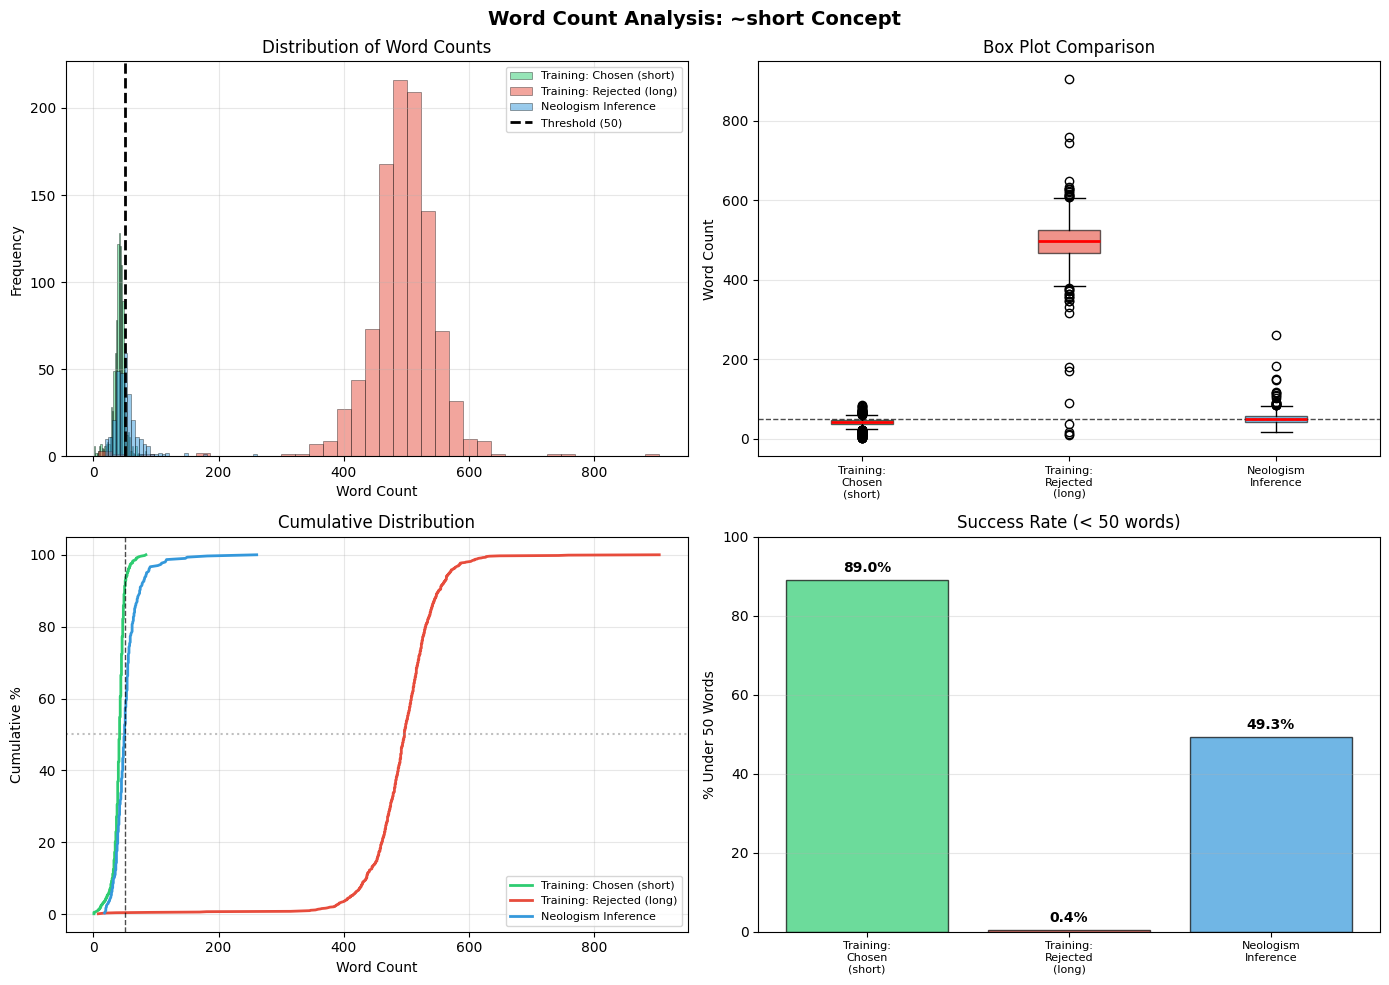

In [11]:
n_datasets = len(datasets)
if n_datasets == 0:
    print("No datasets to visualize.")
else:
    colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Word Count Analysis: ~short Concept', fontsize=14, fontweight='bold')
    
    # 1. Overlaid histograms
    ax1 = axes[0, 0]
    for i, (name, counts) in enumerate(datasets.items()):
        ax1.hist(counts, bins=40, alpha=0.5, label=name, color=colors[i % len(colors)], edgecolor='black', linewidth=0.5)
    ax1.axvline(SHORT_THRESHOLD, color='black', linestyle='--', linewidth=2, label=f'Threshold ({SHORT_THRESHOLD})')
    ax1.set_xlabel('Word Count')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Word Counts')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plots
    ax2 = axes[0, 1]
    bp = ax2.boxplot(datasets.values(), labels=[n.replace(' ', '\n') for n in datasets.keys()],
                     patch_artist=True, medianprops=dict(color='red', linewidth=2))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    ax2.axhline(SHORT_THRESHOLD, color='black', linestyle='--', linewidth=1, alpha=0.7)
    ax2.set_ylabel('Word Count')
    ax2.set_title('Box Plot Comparison')
    ax2.tick_params(axis='x', labelsize=8)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. CDF
    ax3 = axes[1, 0]
    for i, (name, counts) in enumerate(datasets.items()):
        sorted_counts = np.sort(counts)
        cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
        ax3.plot(sorted_counts, cumulative, label=name, color=colors[i % len(colors)], linewidth=2)
    ax3.axvline(SHORT_THRESHOLD, color='black', linestyle='--', linewidth=1, alpha=0.7)
    ax3.axhline(50, color='gray', linestyle=':', alpha=0.5)
    ax3.set_xlabel('Word Count')
    ax3.set_ylabel('Cumulative %')
    ax3.set_title('Cumulative Distribution')
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # 4. Bar chart of % under threshold
    ax4 = axes[1, 1]
    pct_under = [np.sum(c < SHORT_THRESHOLD) / len(c) * 100 for c in datasets.values()]
    bars = ax4.bar(range(len(datasets)), pct_under, color=colors[:len(datasets)], alpha=0.7, edgecolor='black')
    ax4.set_xticks(range(len(datasets)))
    ax4.set_xticklabels([n.replace(' ', '\n') for n in datasets.keys()], fontsize=8)
    ax4.set_ylabel(f'% Under {SHORT_THRESHOLD} Words')
    ax4.set_title(f'Success Rate (< {SHORT_THRESHOLD} words)')
    ax4.set_ylim(0, 100)
    ax4.grid(True, alpha=0.3, axis='y')
    for bar, pct in zip(bars, pct_under):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{pct:.1f}%', 
                 ha='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('short_analysis.png', dpi=300, bbox_inches='tight')
    print("Saved: short_analysis.png")
    plt.show()

## Summary Table

In [12]:
print("=" * 80)
print("SUMMARY TABLE")
print("=" * 80)
print(f"{'Dataset':<30} {'N':>6} {'Mean':>8} {'Std':>8} {'Median':>8} {'<50':>8}")
print("-" * 80)

for name, counts in datasets.items():
    s = all_stats[name]
    pct_under = np.sum(counts < SHORT_THRESHOLD) / len(counts) * 100
    print(f"{name:<30} {s['n']:>6} {s['mean']:>8.2f} {s['std']:>8.2f} {s['median']:>8.2f} {pct_under:>7.1f}%")

print("=" * 80)

SUMMARY TABLE
Dataset                             N     Mean      Std   Median      <50
--------------------------------------------------------------------------------
Training: Chosen (short)         1030    40.94    10.08    42.00    89.0%
Training: Rejected (long)        1030   493.99    60.28   497.00     0.4%
Neologism Inference               300    52.99    23.21    50.00    49.3%
